In [1]:
import logging
import wandb
import hydra
from omegaconf import DictConfig, OmegaConf
from dotenv import load_dotenv
import multiprocessing as mp
import jax.random as jr

# Foundational SSM core imports
from foundational_ssm.models import SSMFoundationalDecoder, SSMDownstreamDecoder
from foundational_ssm.loaders import get_brainset_train_val_loaders
from foundational_ssm.utils.pretrain_utils import (
    train_one_epoch,
    validate_one_epoch,
    load_training_state,
    mse_loss_foundational,
)
from foundational_ssm.utils.wandb_utils_jax import (
    save_checkpoint_wandb,
    add_alias_to_checkpoint,
)
from foundational_ssm.constants import DATA_ROOT
from foundational_ssm.transform import transform_brainsets_regular_time_series_smoothed
import numpy as np

In [ ]:
cfg = OmegaConf.load("../configs/reaching_analysis.yaml")
mp.set_start_method("spawn", force=True)

loss_fn = mse_loss_foundational

train_dataset, train_loader, val_dataset, val_loader, max_neural_input = (
    get_brainset_train_val_loaders(
        cfg.train_loader, cfg.val_loader, cfg.dataset.cfg, data_root="../" + DATA_ROOT
    )
)

from foundational_ssm.utils import load_model_and_state_from_checkpoint_wandb
import equinox as eqx
import jax

artifact_full_name = (
    "melinajingting-ucl/foundational_ssm_downstream_pm/l2_h256_p128_all_checkpoint:v32"
)
model, state, meta = load_model_and_state_from_checkpoint_wandb(
    artifact_full_name, model_cls=SSMDownstreamDecoder
)
inf_model = eqx.nn.inference_mode(model)

In [37]:
sessions = val_dataset.get_session_ids()
sampling_intervals = val_dataset.get_sampling_intervals()

/tmp/ipykernel_1175947/518512436.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  transformed_data = {k: jax.device_put(np.array(v)) for k, v in transformed_data.items()}
/tmp/ipykernel_1175947/518512436.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  transformed_data = {k: jax.device_put(np.array(v)) for k, v in transformed_data.items()}
/tmp/ipykernel_1175947/518512436.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing c

Text(0.5, 0.98, 'Session: perich_miller_population_2018/t_20130819_center_out_reaching, Overall R2: 0.85')

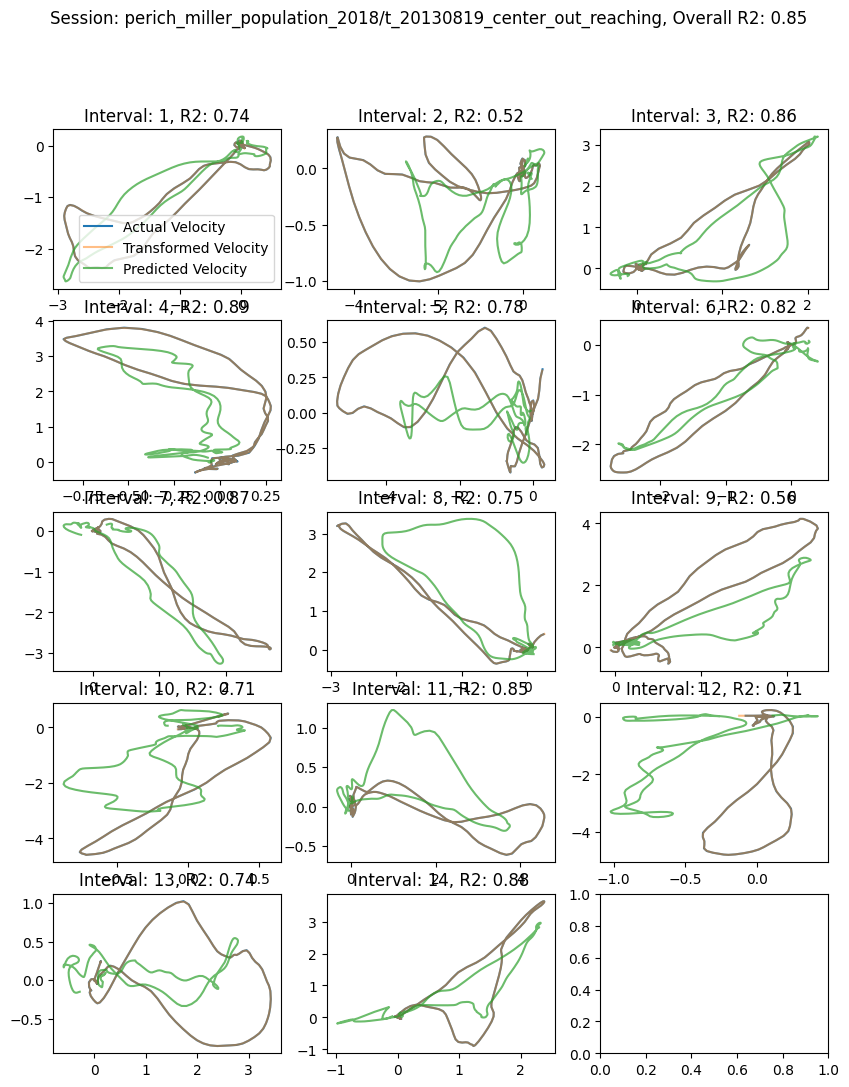

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# for session_id, intervals in sampling_intervals.items():
# session_id = 'perich_miller_population_2018/c_20131003_center_out_reaching'
error_session_intervals = []
max_values = []
fig, axs = plt.subplots(5, 3, figsize=(10, 12))
axs = axs.flatten()

all_preds = []
all_targets = []

for session_id in sessions:
    if ("perich_miller_population_2018/t" in session_id) and (
        "center_out" in session_id
    ):
        intervals = sampling_intervals[session_id]
        for i in range(14):
            start, end = intervals.start[i], intervals.end[i]
            data = train_dataset.get_recording_data(session_id).slice(start, end)
            transformed_data = transform_brainsets_regular_time_series_smoothed(
                data, max_neural_units=72
            )
            transformed_data = {
                k: jax.device_put(np.array(v)) for k, v in transformed_data.items()
            }
            actual_vel = data.cursor.vel
            actual_timestamps = data.cursor.timestamps
            transformed_vel = transformed_data["behavior_input"]
            pred_vel, state = inf_model(
                transformed_data["neural_input"], state, jr.PRNGKey(0)
            )
            targets = transformed_vel[56:]
            preds = pred_vel[56:]

            all_preds.append(preds)
            all_targets.append(targets)

            max_value = int(np.abs(transformed_vel).max())
            max_values.append(max_value)

            actual_vel_norm = actual_vel / (np.array([21.67696, 25.117935]) ** 0.5)
            axs[i].plot(
                actual_vel_norm[:, 0], actual_vel_norm[:, 1], label="Actual Velocity"
            )
            axs[i].plot(
                transformed_vel[:, 0],
                transformed_vel[:, 1],
                label="Transformed Velocity",
                alpha=0.5,
            )
            axs[i].plot(
                pred_vel[:, 0], pred_vel[:, 1], label="Predicted Velocity", alpha=0.7
            )
            axs[i].set_title(
                f"Interval: {i + 1}, R2: {r2_score(transformed_vel, pred_vel, multioutput='variance_weighted'):.2f}"
            )
        break
axs[0].legend()
plt.suptitle(
    f"Session: {session_id}, Overall R2: {r2_score(np.concatenate(all_targets).reshape(-1, 2), np.concatenate(all_preds).reshape(-1, 2), multioutput='uniform_average'):.2f}"
)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# for session_id, intervals in sampling_intervals.items():
# session_id = 'perich_miller_population_2018/c_20131003_center_out_reaching'
error_session_intervals = []
max_values = []
fig, axs = plt.subplots(5, 3, figsize=(10, 12))
axs = axs.flatten()

all_preds = []
all_targets = []

for session_id in sessions:
    if ("churchland_shenoy_neural_2012/jenkins" in session_id) and (
        "center_out" in session_id
    ):
        intervals = sampling_intervals[session_id]
        for i in range(14):
            start, end = intervals.start[i], intervals.end[i]
            data = train_dataset.get_recording_data(session_id).slice(start, end)
            transformed_data = transform_brainsets_regular_time_series_smoothed(
                data, max_neural_units=72
            )
            transformed_data = {
                k: jax.device_put(np.array(v)) for k, v in transformed_data.items()
            }
            actual_vel = data.cursor.vel
            actual_timestamps = data.cursor.timestamps
            transformed_vel = transformed_data["behavior_input"]
            pred_vel, state = inf_model(
                transformed_data["neural_input"], state, jr.PRNGKey(0)
            )
            targets = transformed_vel[56:]
            preds = pred_vel[56:]

            all_preds.append(preds)
            all_targets.append(targets)

            max_value = int(np.abs(transformed_vel).max())
            max_values.append(max_value)

            actual_vel_norm = actual_vel / (np.array([21.67696, 25.117935]) ** 0.5)
            axs[i].plot(
                actual_vel_norm[:, 0], actual_vel_norm[:, 1], label="Actual Velocity"
            )
            axs[i].plot(
                transformed_vel[:, 0],
                transformed_vel[:, 1],
                label="Transformed Velocity",
                alpha=0.5,
            )
            axs[i].plot(
                pred_vel[:, 0], pred_vel[:, 1], label="Predicted Velocity", alpha=0.7
            )
            axs[i].set_title(
                f"Interval: {i + 1}, R2: {r2_score(transformed_vel, pred_vel, multioutput='variance_weighted'):.2f}"
            )
        break
axs[0].legend()
plt.suptitle(
    f"Session: {session_id}, Overall R2: {r2_score(np.concatenate(all_targets).reshape(-1, 2), np.concatenate(all_preds).reshape(-1, 2), multioutput='uniform_average'):.2f}"
)

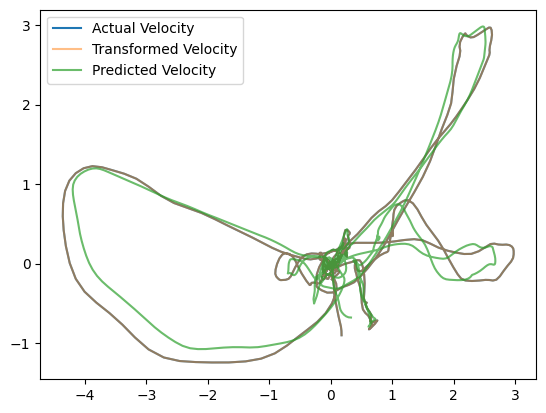

In [23]:
import matplotlib.pyplot as plt

actual_vel_norm = actual_vel / (np.array([21.67696, 25.117935]) ** 0.5)
plt.plot(actual_vel_norm[:, 0], actual_vel_norm[:, 1], label="Actual Velocity")
plt.plot(
    transformed_vel[:, 0],
    transformed_vel[:, 1],
    label="Transformed Velocity",
    alpha=0.5,
)
plt.plot(pred_vel[:, 0], pred_vel[:, 1], label="Predicted Velocity", alpha=0.7)

plt.legend()

In [ ]:
for session_id in sessions:
    if ("perich/jenkins" in session_id) and ("center_out" in session_id):
        intervals = sampling_intervals[session_id]
        for i in range(len(intervals.start)):
            start, end = intervals.start[i], intervals.end[i]
            error_session_intervals.append((session_id, start, end))
            if i > 15:
                break
        break

In [47]:
import equinox as eqx
import jax
import numpy as np
import jax.numpy as jnp

inf_model = eqx.nn.inference_mode(model)
for batch in val_loader:
    batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
    dataset_group_idxs = batch["dataset_group_idx"]
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    mask = batch["mask"]
    preds, state = jax.vmap(
        inf_model, axis_name="batch", in_axes=(0, None, None), out_axes=(0, None)
    )(inputs, state, jr.PRNGKey(0))
    preds = jnp.where(mask[..., None], preds, 0)
    break

/tmp/ipykernel_1175947/1062013270.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}


0.8477240204811096


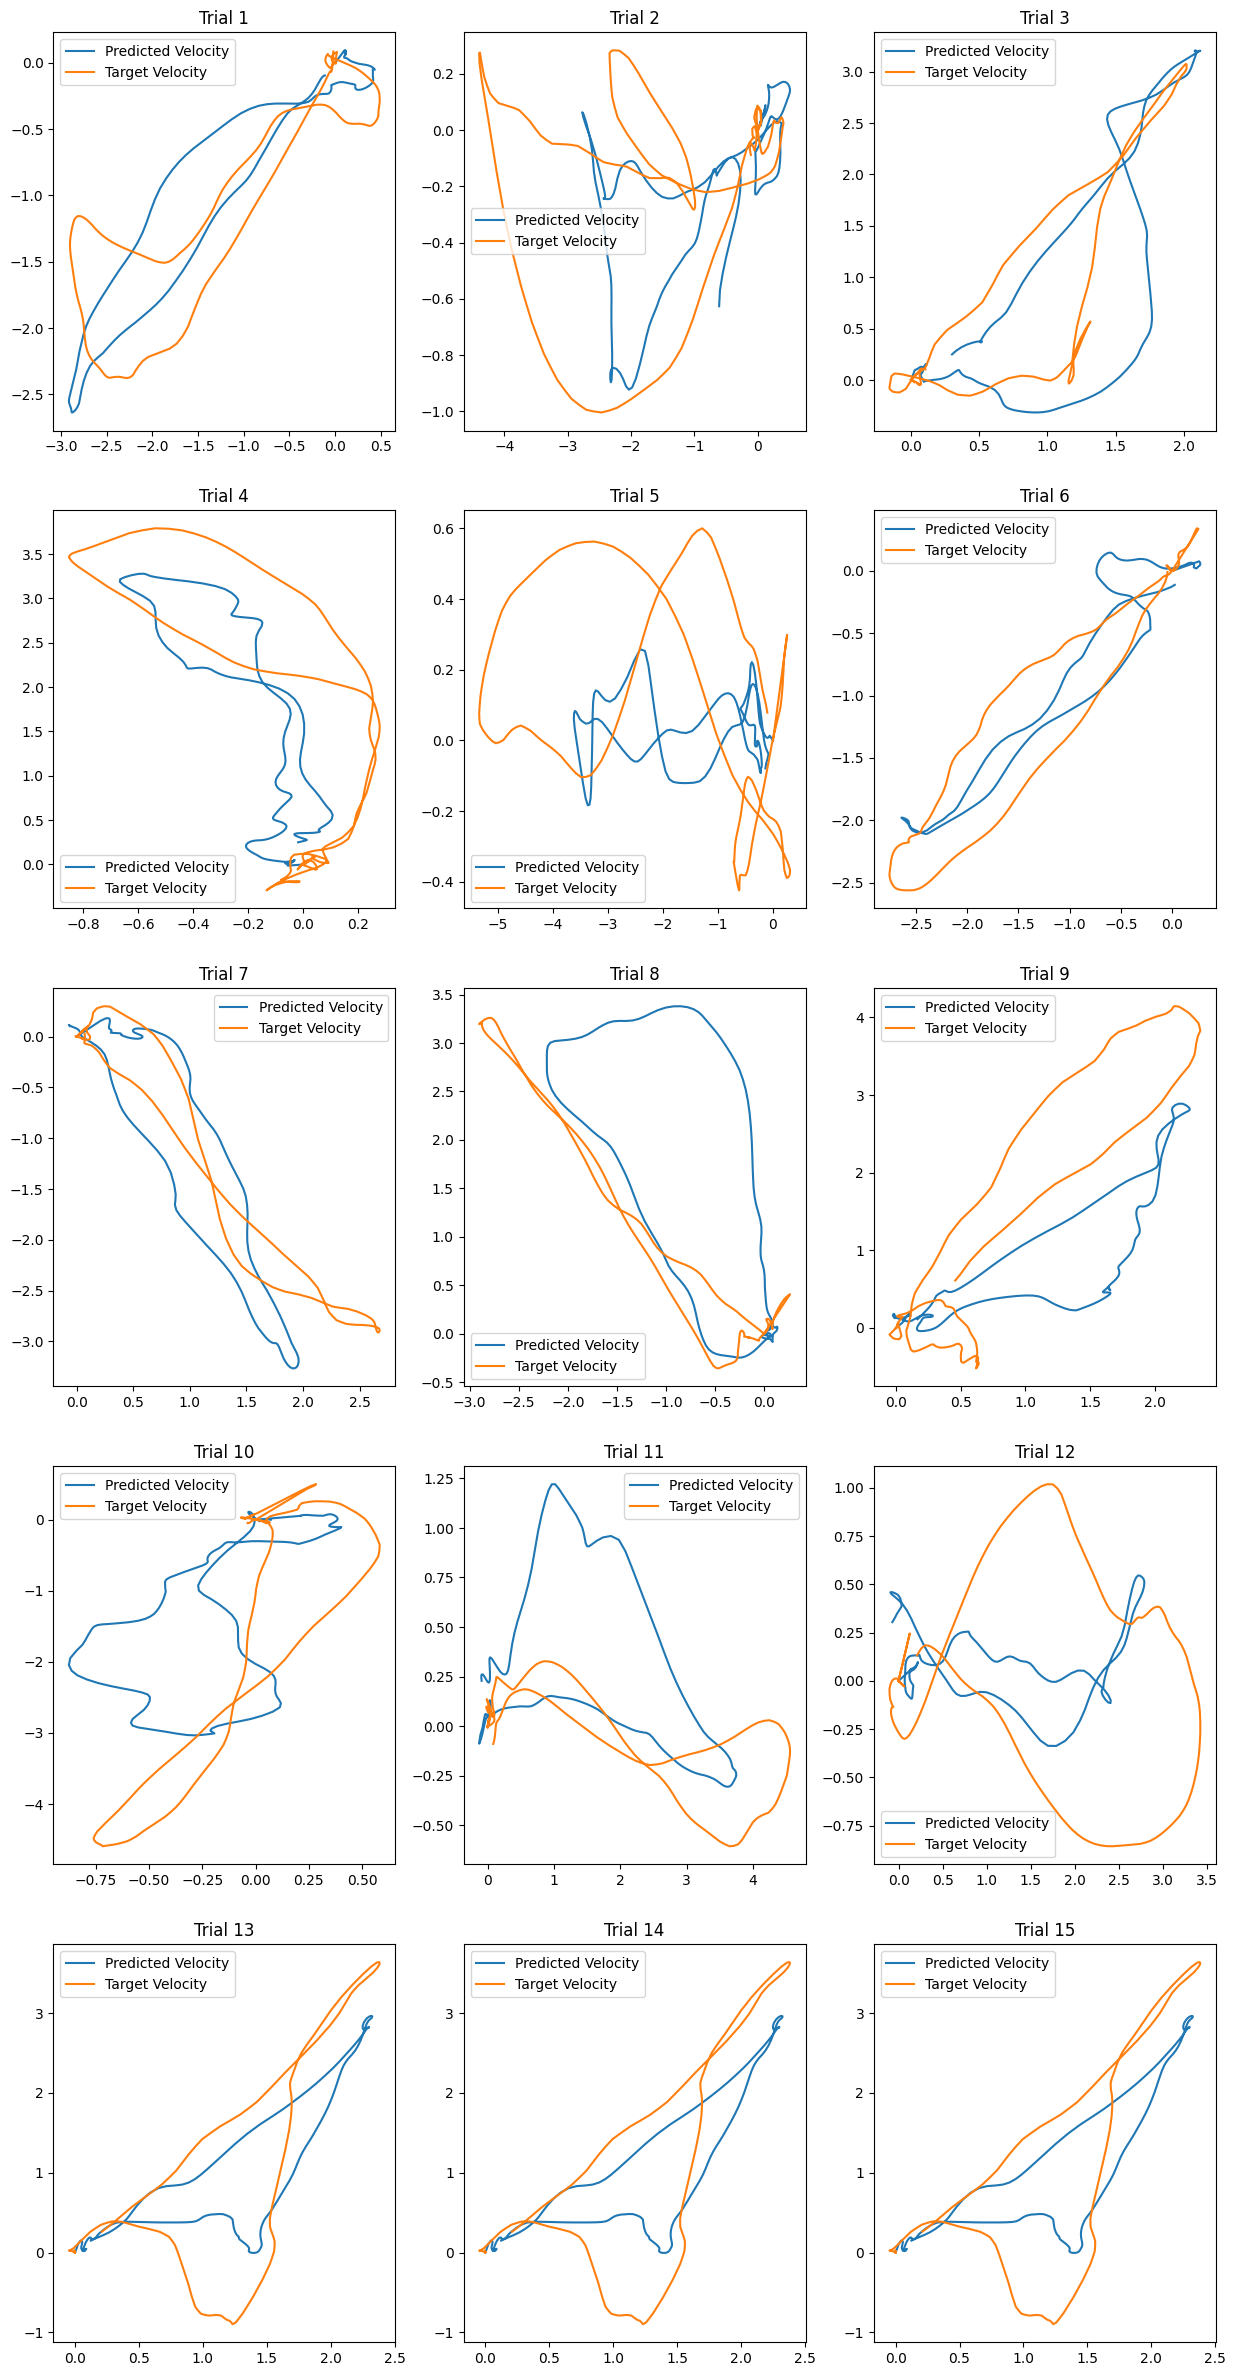

In [48]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 3, figsize=(15, 30))
axs = axs.flatten()
for i in range(15):
    pred = preds[i]
    target = targets[i]
    ax = axs[i]
    ax.plot(pred[56:, 0], pred[56:, 1], label="Predicted Velocity")
    ax.plot(target[56:, 0], target[56:, 1], label="Target Velocity")
    ax.set_title(f"Trial {i + 1}")
    ax.legend()

r2 = r2_score(targets.reshape(-1, 2), preds.reshape(-1, 2))
print(r2)

In [ ]:
import equinox as eqx
import jax
import numpy as np

inf_model = eqx.nn.inference_mode(model)
for batch in train_loader:
    batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
    dataset_group_idxs = batch["dataset_group_idx"]
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    preds, state = jax.vmap(
        inf_model, axis_name="batch", in_axes=(0, None, 0, None), out_axes=(0, None)
    )(inputs, state, dataset_group_idxs, jr.PRNGKey(0))
    break

Array([[-7.50762701e-01,  7.15551972e-01],
       [ 4.96246994e-01,  9.42009330e-01],
       [ 1.26909173e+00,  6.34847224e-01],
       [ 1.29479671e+00,  4.63485032e-01],
       [ 1.43883741e+00,  3.23007107e-01],
       [ 1.26269090e+00,  4.44091439e-01],
       [ 1.10274088e+00,  5.39195120e-01],
       [ 8.50049376e-01,  5.18778443e-01],
       [ 5.28473496e-01,  2.40396246e-01],
       [ 2.86024839e-01,  4.95016500e-02],
       [ 1.57339096e-01,  7.26777166e-02],
       [ 9.82696563e-02,  1.21970966e-01],
       [ 9.73211750e-02,  1.29689470e-01],
       [ 1.15203470e-01,  1.64411202e-01],
       [ 1.40704960e-01,  2.02334061e-01],
       [ 1.58815235e-01,  2.22856045e-01],
       [ 1.79030836e-01,  2.47066662e-01],
       [ 1.93202883e-01,  2.54177243e-01],
       [ 2.09601641e-01,  2.60508239e-01],
       [ 2.24844873e-01,  2.69013494e-01],
       [ 2.38748059e-01,  2.80483782e-01],
       [ 2.52385676e-01,  2.98432857e-01],
       [ 2.68432260e-01,  3.20804000e-01],
       [ 2.